In [1]:
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator
from matplotlib import rcParams as rc
import numpy as np
import bisect
import os
import glob
import pandas as pd
from pybaselines import Baseline
import matplotlib.cm as cm
import matplotlib.colors as mcolors
#%matplotlib widget

#plt.rcdefaults()
#rc.update({'figure.autolayout': True})
plt.style.use('mystyle.mplstyle.txt')

"""
x, y:   Raw X and Y
b:      Baseline
bsy:    Baseline Substracted Y
ny:     Normalized Y
bnY:    Baseline of Normalized Y
nbsy:   Normalized and Baseline Substracted Y
bsny:   Baseline Substracted of Normalized Y

"""

def comma_to_float(s):
    return float(s.replace(b',', b'.'))

def normalize_data(x, y, peak_range=None):
    """
    Normalize y to 0–100.
    If peak_range=(xmin, xmax) is given, max y in that range is used for normalization.
    """
    y = np.array(y)
    x = np.array(x)
    data_min = y.min()

    if peak_range:
        xmin, xmax = peak_range
        mask = (x >= xmin) & (x <= xmax)
        if not any(mask):
            raise ValueError(f"No data points found in the specified range {peak_range}")
        data_max = y[mask].max()
    else:
        data_max = y.max()

    normalized_data = ((y - data_min) / (data_max - data_min)) * 100
    return normalized_data

def baseline_maker(x, y, lam=1e7, p=0.02):
    """Returns baseline and baseline corrected data"""
    baseline_fitter = Baseline(x_data=x)
    b, params = baseline_fitter.asls(y, lam, p)
    bsy = y - b
    return b, bsy



def plot_data(file, out_path = os.getcwd(), x_min=None, x_max=None):     #color_index chooses color from the colors list 
    """Ploting from text file in a folder and save data to the output folder"""

    file_name = os.path.splitext(os.path.basename(file))[0]     #Getting the filename without the extension for creating labels and output
    raman = np.loadtxt(file)     #Loading the txt file data

    x, y = raman[:, 0], raman[:, 1]      #Getting x and y data points to plot
    
    if x_min == None:
        x_min = min(x)
    if x_max == None:
        x_max = max(x)
        
    fig, ax = plt.subplots()
    plt.plot(x, y, label = file_name)         #i is the color index
    plt.xlim(x_min, x_max)
    plt.xlabel('Raman shift')
    plt.ylabel('Intensity (a.u.)')
    plt.title(file_name)
    plt.legend()
    plt.show()

    os.makedirs(out_path, exist_ok=True)      #Checking if the output directory exsits otherwise creates one
    fig.savefig(out_path + '/' + file_name, format='svg')        #Saving the svg files in desired folder
    print('Plot have been saved to ' + out_path)


def plot_baseline_corrected_data(file, out_path = os.getcwd(), lam_value=1e7, p_value=0.02, x_min=None, x_max=None, peak_range=None, size=(8,6)):     #color_index chooses color from the colors list 
    """Ploting from text file in a folder and save data to the output folder"""

    out_path_raw = out_path + '/raw_plots/'
    out_path_norm = out_path + '/normalized_plots/'
    out_path_norm_baseline_sub = out_path + '/norm_baseline_sub_plots/'
    out_path_raw_and_processed = out_path + '/raw_and_processed_plots/'
    out_path_files = out_path +'/plot_files/'

    file_name = os.path.splitext(os.path.basename(file))[0]     #Getting the filename without the extension for creating labels and output
    raman = np.loadtxt(file, converters={0: comma_to_float, 1: comma_to_float})     #Loading the txt file data

    x, y = raman[:, 0], raman[:, 1]      #Getting x and y data points to plot
    b, bsy = baseline_maker(x, y, lam = lam_value, p = p_value)
    
    ny = normalize_data(x, y, peak_range)
    bny, bsny = baseline_maker(x, ny, lam = lam_value, p = p_value)   #Getting baseline of Normalized Y and baseline substraction of normalized Y
    nbsy = normalize_data(x, bsy, peak_range)     #Normalized and baseline corrected y axis

    data = {'Raman Shift' : x,
            'Raw' : y,
            'Normalized': ny,
            'Baseline Substracted': bsy,
            'Baseline': b,
            'Normalized and Baseline Substracted': nbsy,
            'Baseline of Normalized': bny
           }
    df = pd.DataFrame(data)
    os.makedirs(out_path_files, exist_ok=True)      #Checking if the output directory exsits otherwise creates one
    df.to_csv(out_path_files + file_name + '_processed' + '.csv', index= False)
    df.to_csv(out_path_files + file_name + '_processed' + '.txt', sep= '\t', index= False, header= True)
    
    #If needed individual files activate this subsection
    """
    raw_df = pd.DataFrame({'Raman Shift': x, 'Raw Intensity': y})
    norm_df = pd.DataFrame({'Raman Shift': x, 'Normalized Intensity': ny})
    bs_df = pd.DataFrame({'Raman Shift': x, 'Baseline Subtracted Intensity': bsy})
    norm_bs_df = pd.DataFrame({'Raman Shift': x, 'Normalized + Baseline Subtracted Intensity': nbsy})

    raw_df.to_csv(os.path.join(out_path, f"{file_name}_raw.txt"), sep="\t", index=False)
    norm_df.to_csv(os.path.join(out_path, f"{file_name}_normalized.txt"), sep="\t", index=False)
    bs_df.to_csv(os.path.join(out_path, f"{file_name}_baseline_corrected.txt"), sep="\t", index=False)
    norm_bs_df.to_csv(os.path.join(out_path, f"{file_name}_baseline_corrected_normalized.txt"), sep="\t", index=False)
    """
    

    if x_min == None:
        x_min = min(x)
    if x_max == None:
        x_max = max(x)
    
    
    fig1, ax1 = plt.subplots(figsize=size)
    """for axis in ['top', 'bottom', 'left', 'right']:
        ax1.spines[axis].set_linewidth(1.5)
    plt.tick_params(width = 1.5, length = 10)"""
    ax1.xaxis.set_major_locator(MultipleLocator(100))
    ax1.xaxis.set_minor_locator(MultipleLocator(20))
    plt.xlim(x_min, x_max)
    plt.plot(x, y, label = file_name + ' Raw')        
    plt.xlabel('Raman Shift (cm$^{-1}$)')
    plt.ylabel('Intensity (a.u.)')
    plt.title("Raw - " + file_name )
    plt.legend()
    plt.show()
    os.makedirs(out_path_raw, exist_ok=True)      #Checking if the output directory exsits otherwise creates one
    fig1.savefig(out_path_raw + file_name +'_raw.svg', format='svg')        #Saving the svg files in desired folder
    
    fig2, ax2 = plt.subplots(figsize=size)
    #plt.tick_params(labelleft = False ,left=False)
    ax2.xaxis.set_major_locator(MultipleLocator(100))
    ax2.xaxis.set_minor_locator(MultipleLocator(20))
    plt.xlim(x_min, x_max)
    plt.plot(x, nbsy, label = file_name)        
    plt.xlabel('Raman Shift (cm$^{-1}$)')
    plt.ylabel('Normalized Intensity (a.u.)')
    plt.title("Normalized and Baseline Substracted - " + file_name )
    plt.legend()
    plt.show()
    os.makedirs(out_path_norm_baseline_sub, exist_ok=True)      #Checking if the output directory exsits otherwise creates one
    fig2.savefig(out_path_norm_baseline_sub + file_name +'_processed.svg', format='svg')        #Saving the svg files in desired folder
    
    fig3, ax3 = plt.subplots(figsize=size)
    plt.tick_params(labelleft = False ,left=False)
    ax3.xaxis.set_major_locator(MultipleLocator(100))
    ax3.xaxis.set_minor_locator(MultipleLocator(20))
    plt.xlim(x_min, x_max)
    plt.plot(x,np.array(bsny), label = file_name + ' Normalized and Baseline Substracted')
    plt.plot(x,np.array(ny)+20, label = file_name + ' Normalized')
    plt.plot(x,np.array(bny)+20, label = file_name + ' Baseline of normalized Y')      
    plt.xlabel('Raman Shift (cm$^{-1}$)')
    plt.ylabel('Normalized Intensity (a.u.)')
    plt.title("Raw - " + file_name )
    plt.legend()
    plt.show()
    os.makedirs(out_path_raw_and_processed, exist_ok=True)      #Checking if the output directory exsits otherwise creates one
    fig3.savefig(out_path_raw_and_processed + file_name +'_compare.svg', format='svg')        #Saving the svg files in desired folder
    
    print('Plot have been saved to ' + out_path)

    
def stack_plot_raw_norm(folder_path, offset = 10, no_of_plots = 5):      #color_index chooses color from the colors list 
    """Ploting stack from text files and save data"""
    txt_files = glob.glob(folder_path)
    fig, ax = plt.subplots()
    i = 0

    for txt_file in txt_files:
        file_name = os.path.splitext(os.path.basename(txt_file))[0]     #Getting the filename without the extension for final filename
        raman = np.loadtxt(txt_file)     #Loading the txt file data
        x, y = raman[:, 0], raman[:,1]      #Getting x and y data points to plot
        ny = np.array(normalize_data(y))    #Normalize y axis between o to 100 
        ax.plot(x, ny + i*offset, label = file_name, alpha = 0.75)
        i += 1
        if i == no_of_plots:
            break
    #plt.xlim(start no. , stop no.)     #For croping on xaxis 

    plt.xlabel('Raman shift (cm$^{-1}$)')
    plt.ylabel('Intensity (a.u.)')
    plt.title("Normalized Stacked Plot " + file_name )
    plt.legend()
    plt.show()
    fig.savefig('stacked_normalized.svg', format='svg')
    
def stack_plot_bs_norm(folder_path, outpath = '', offset = 10, no_of_plots = 5, lam_value=1e7, p_value=0.02, x_min=None, x_max=None, peak_range=None, size=(8,6)):      #color_index chooses color from the colors list 
    """Ploting stack from text files and save data"""
    txt_files = glob.glob(folder_path)
    txt_files.sort()
    fig, ax = plt.subplots(figsize=size)
    i = 0

    colormap =  cm.get_cmap('viridis', 6)
    
    for txt_file in txt_files:
        file_name = os.path.splitext(os.path.basename(txt_file))[0]     #Getting the filename without the extension for final filename
        raman = np.loadtxt(txt_file, converters={0: comma_to_float, 1: comma_to_float})     #Loading the txt file data
        x, y = raman[:, 0], raman[:,1]      #Getting x and y data points to plot
        b, bsy = baseline_maker(x, y, lam = lam_value, p = p_value)
        
        ny = normalize_data(x, y, peak_range)
        bny, bsny = baseline_maker(x, ny, lam = lam_value, p = p_value)   #Getting baseline of Normalized Y and baseline substraction of normalized Y
        nbsy = normalize_data(x, bsy, peak_range)     #Normalized and baseline corrected y axis  
         
        if x_min == None:
                x_min = min(x)
        if x_max == None:
                x_max = max(x)
        color =  colormap(i)
        
        ax.plot(x,np.array(nbsy) + i*offset, label = file_name, color=color, alpha = 1)
        i += 1
        if i == no_of_plots:
            break
        
    plt.tick_params(labelleft = False ,left=False)
    ax.xaxis.set_major_locator(MultipleLocator(100))
    ax.xaxis.set_minor_locator(MultipleLocator(20))
    plt.xlim(x_min, x_max)     #For croping on xaxis 
    plt.xlabel('Raman shift (cm$^{-1}$)')
    plt.ylabel('Normalized Intensity (a.u.)')
    plt.title("Normalized Stacked Plot" )
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.show()
    os.makedirs(outpath, exist_ok=True)      #Checking if the output directory exsits otherwise creates one
    fig.savefig(outpath + '/' + 'stacked_normalized.svg', format='svg')
    
def stack_plot_from_files(folder_path, outpath = '', offset = 10, no_of_plots = 10, lam_value=1e7, p_value=0.02, x_min=None, x_max=None, peak_range=None, size=(8,6)):      #color_index chooses color from the colors list 
    """Ploting stack from text files and save data"""
    txt_files = glob.glob(folder_path)
    txt_files.sort()
    fig, ax = plt.subplots(figsize=size)
    i = 0

    colormap =  cm.get_cmap('Dark2')
    
    for txt_file in txt_files:
        file_name = os.path.splitext(os.path.basename(txt_file))[0]     #Getting the filename without the extension for final filename
        raman = pd.read_csv(txt_file, sep='\t')
        x = raman['Raman Shift']
        y = raman['Normalized and Baseline Substracted']
        
        if x_min == None:
                x_min = min(x)
        if x_max == None:
                x_max = max(x)
        color =  colormap(i)
        
        ax.plot(x, y + i*offset, label = file_name, color=color, alpha = 1)
        i += 1
        if i == no_of_plots:
            break
        
    plt.tick_params(labelleft = False ,left=False)
    ax.xaxis.set_major_locator(MultipleLocator(100))
    ax.xaxis.set_minor_locator(MultipleLocator(20))
    plt.xlim(x_min, x_max)     #For croping on xaxis 
    plt.xlabel('Raman shift (cm$^{-1}$)')
    plt.ylabel('Normalized Intensity (a.u.)')
    plt.title("Normalized Stacked Plot" )
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.show()
    os.makedirs(outpath, exist_ok=True)      #Checking if the output directory exsits otherwise creates one
    fig.savefig(outpath + '/' + 'stacked_normalized.svg', format='svg')
    

In [3]:
file_path = 
out_path = 
txt_files = glob.glob(filepath + "\\*.txt")
for txt in txt_files:
    plot_baseline_corrected_data(txt, out_path )

SyntaxError: invalid syntax (3468579598.py, line 1)

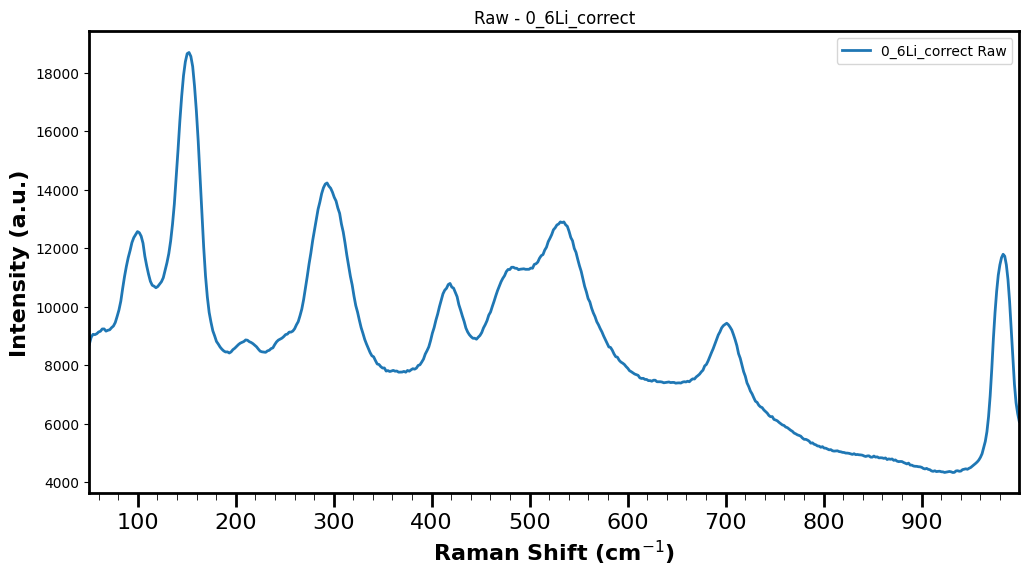

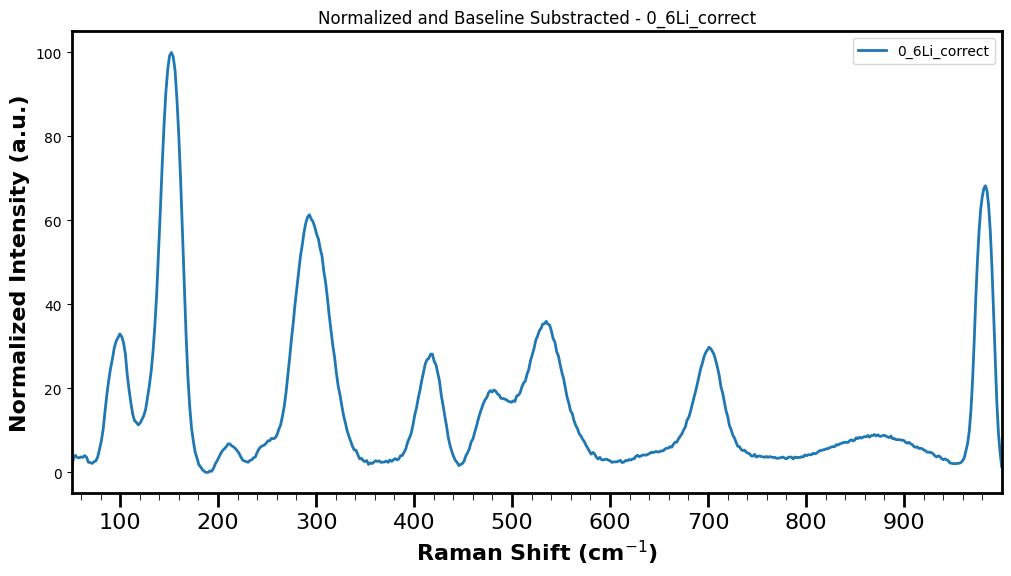

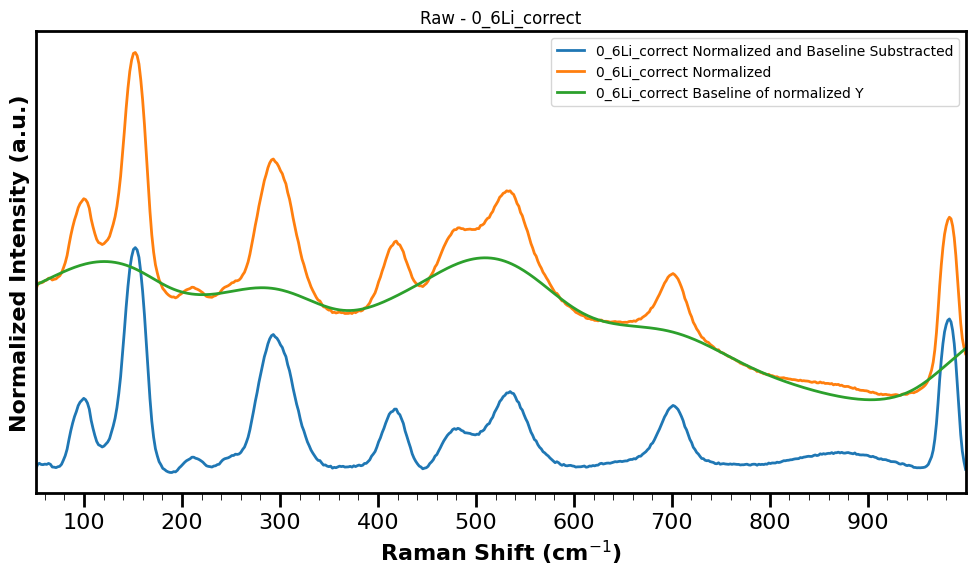

Plot have been saved to C:\Users\write\OneDrive\Documents\Banerjee_Lab\Projects\Vanadium_Oxide\RAMAN\li_a_V2O5\improved\New_plots\plot_figs


In [8]:
out_path = r"C:\Users\write\OneDrive\Documents\Banerjee_Lab\Projects\Vanadium_Oxide\RAMAN\li_a_V2O5\improved\New_plots\plot_figs"
plot_baseline_corrected_data(r"C:\Users\write\OneDrive\Documents\Banerjee_Lab\Projects\Vanadium_Oxide\RAMAN\li_a_V2O5\improved\0_6Li_correct.txt", out_path, lam_value=1e4, size=(12, 6))

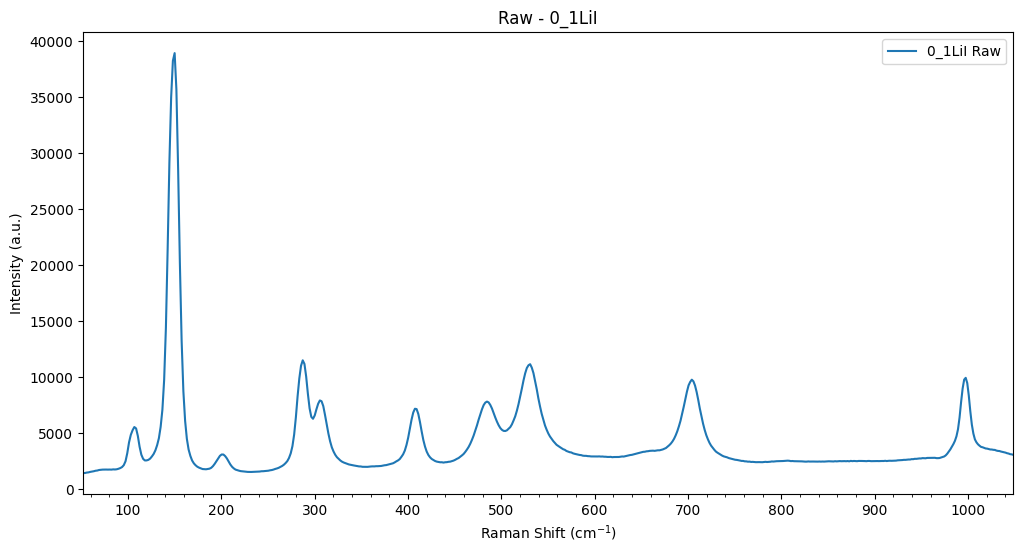

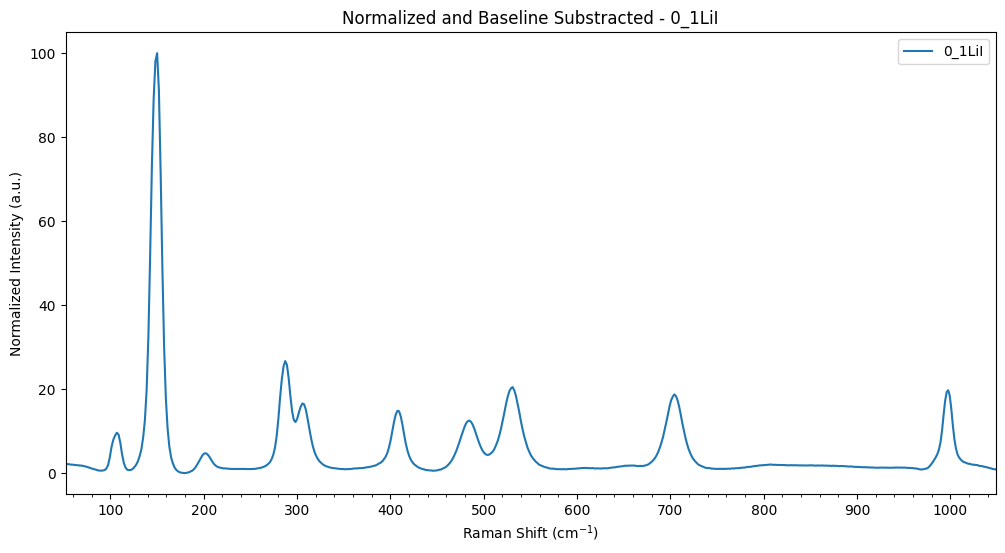

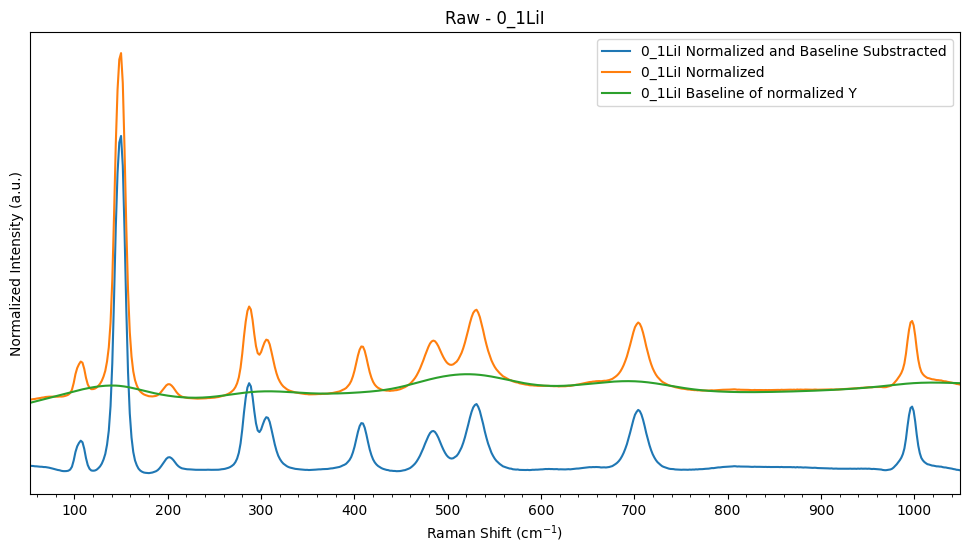

Plot have been saved to C:\Users\write\OneDrive\Documents\Banerjee_Lab\Projects\Vanadium_Oxide\RAMAN\li_a_V2O5\improved\New_plots\plot_figs


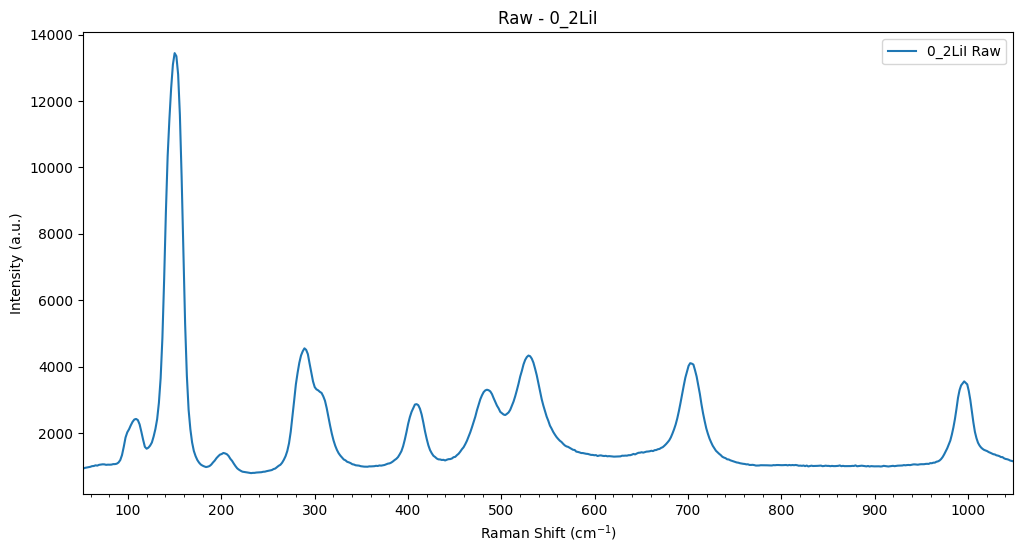

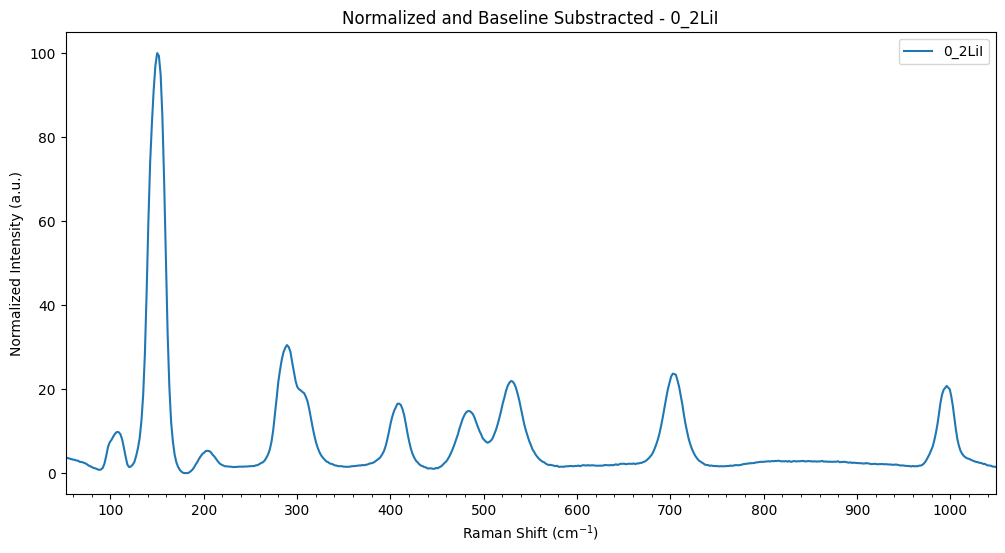

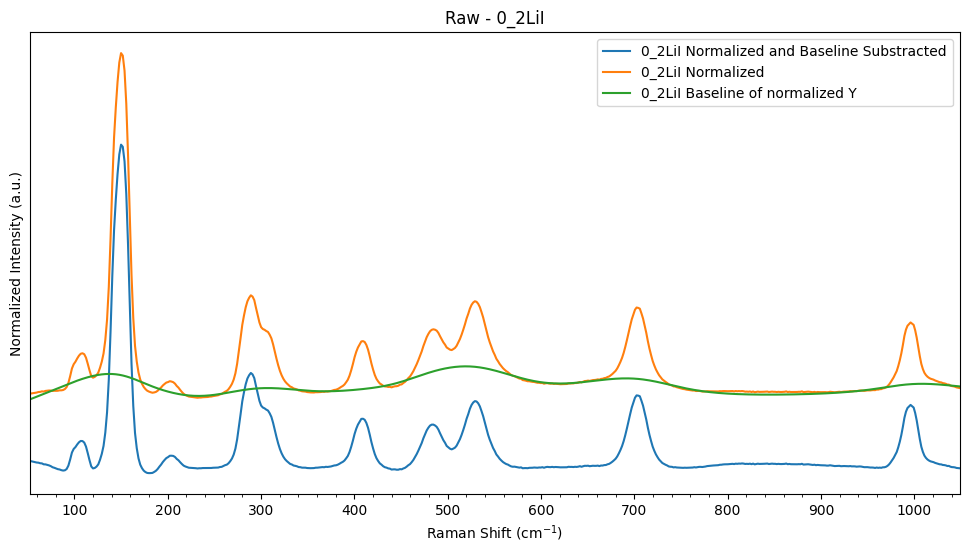

Plot have been saved to C:\Users\write\OneDrive\Documents\Banerjee_Lab\Projects\Vanadium_Oxide\RAMAN\li_a_V2O5\improved\New_plots\plot_figs


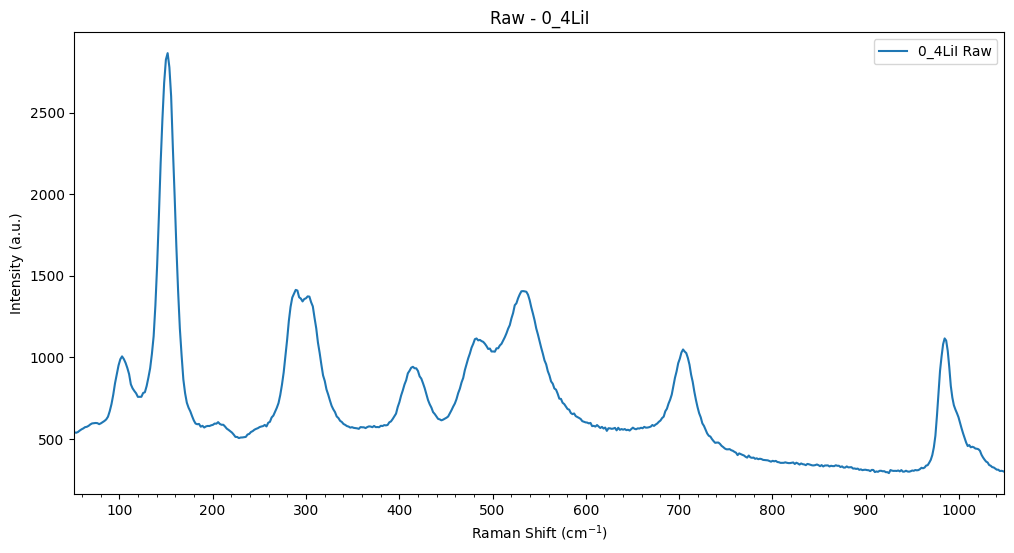

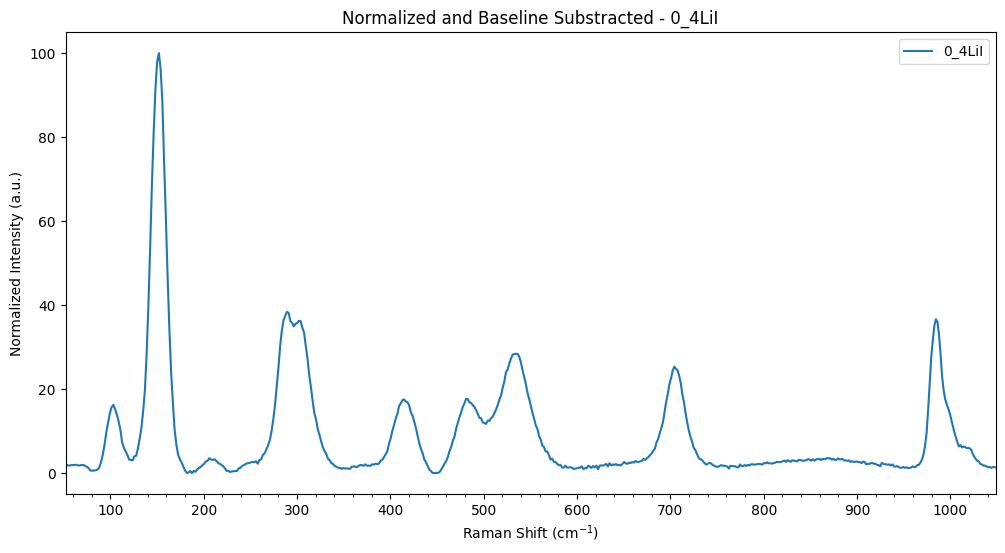

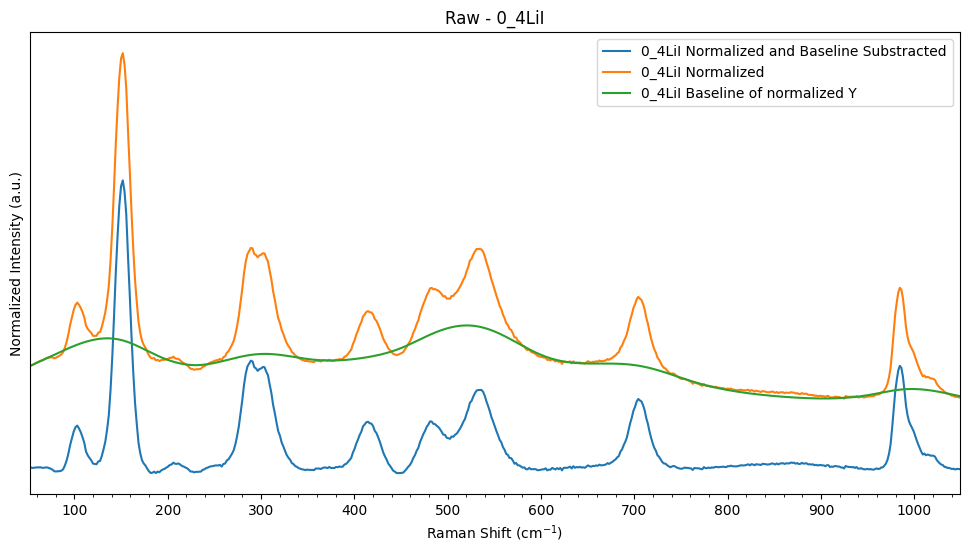

Plot have been saved to C:\Users\write\OneDrive\Documents\Banerjee_Lab\Projects\Vanadium_Oxide\RAMAN\li_a_V2O5\improved\New_plots\plot_figs


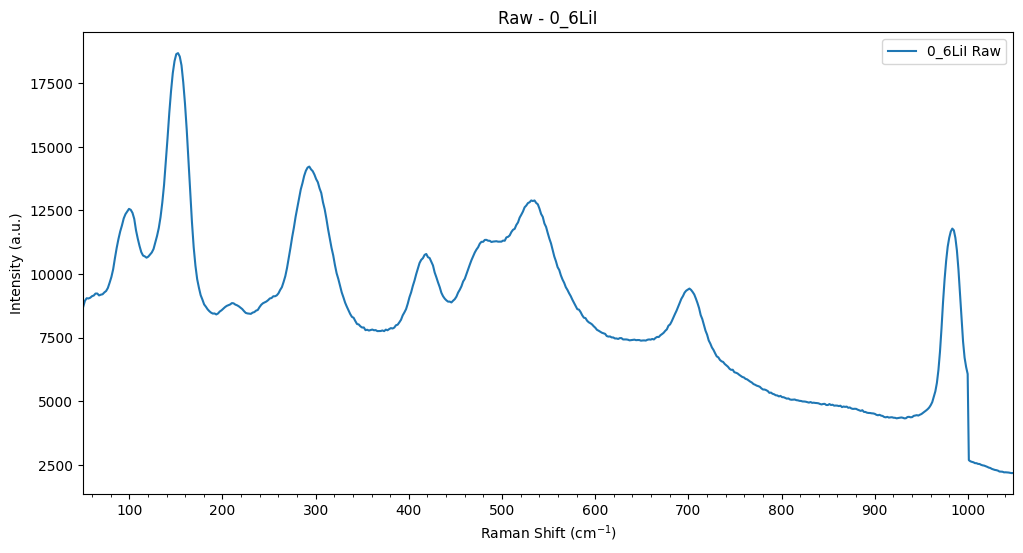

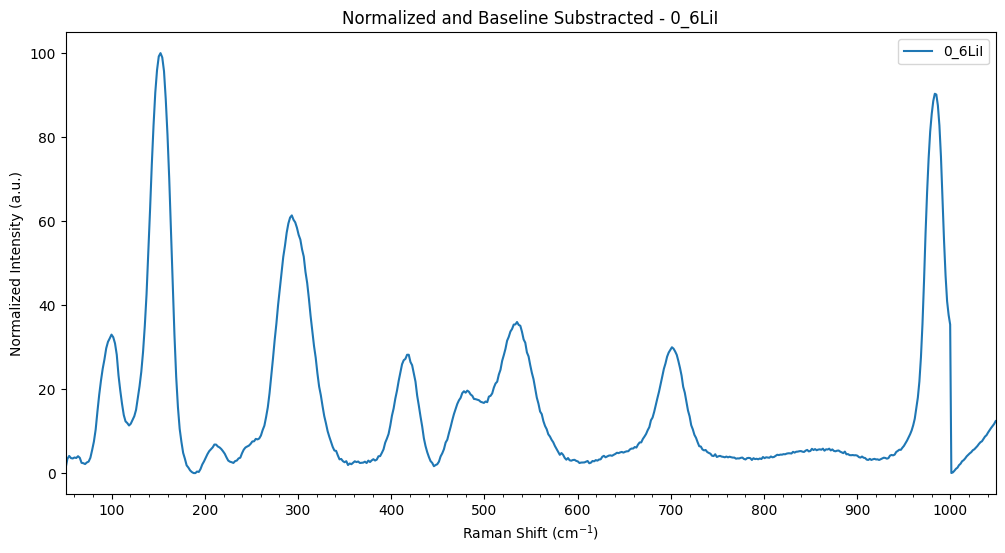

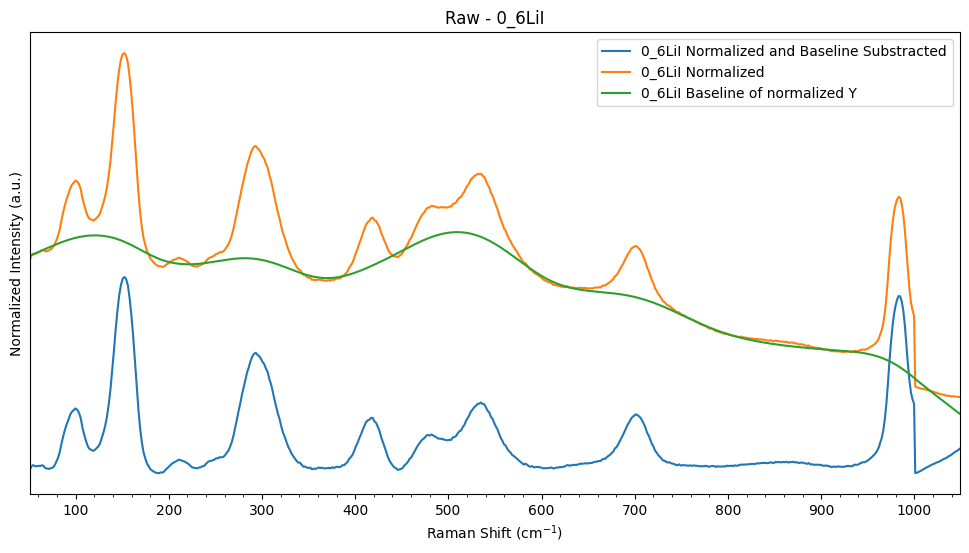

Plot have been saved to C:\Users\write\OneDrive\Documents\Banerjee_Lab\Projects\Vanadium_Oxide\RAMAN\li_a_V2O5\improved\New_plots\plot_figs


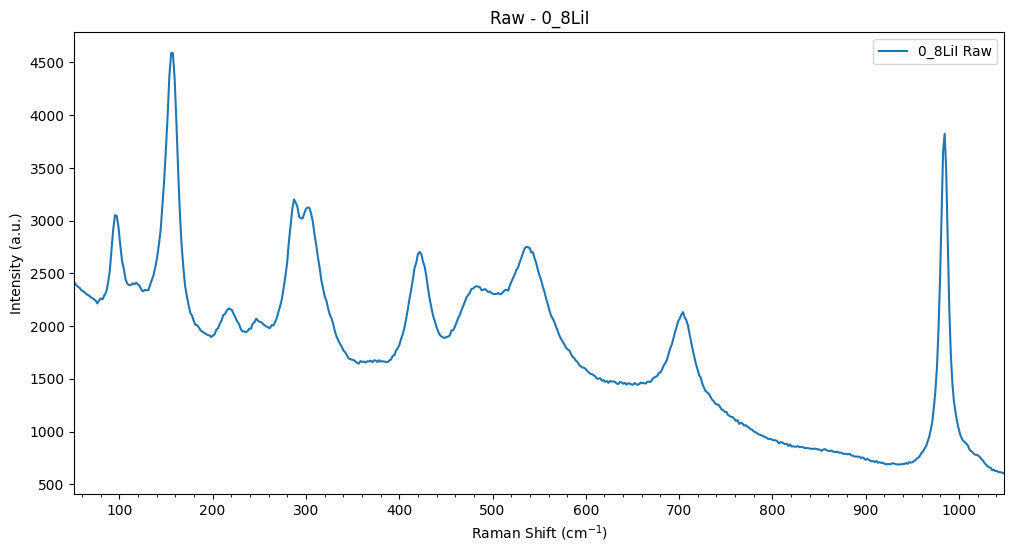

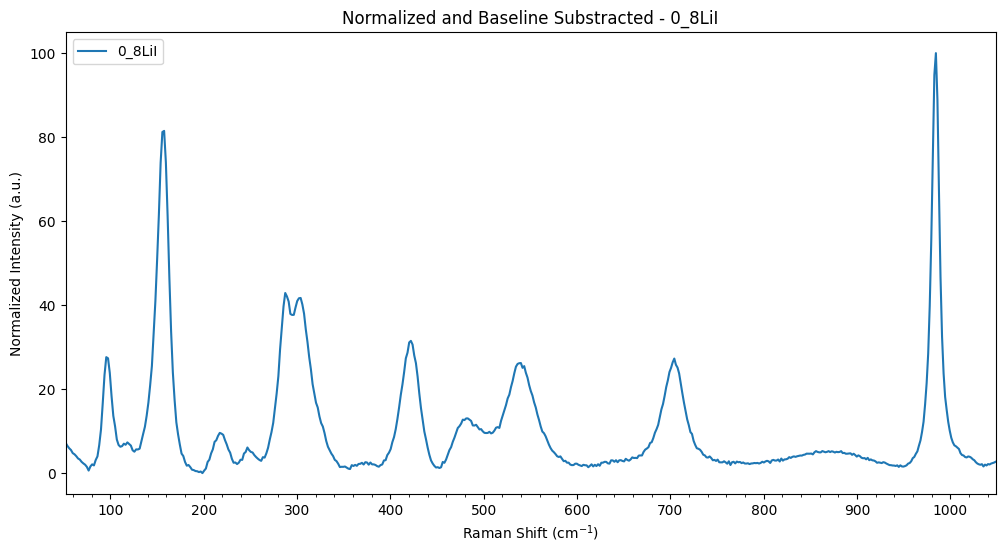

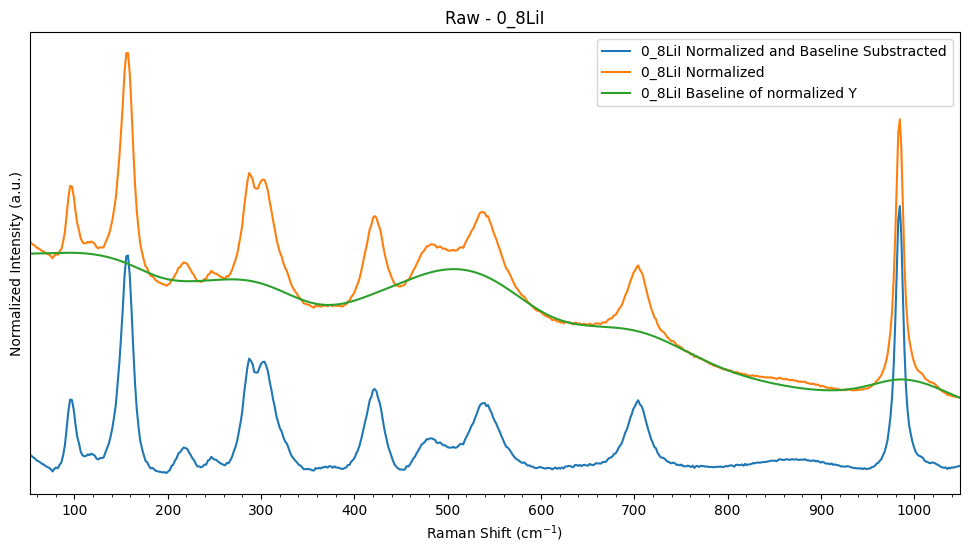

Plot have been saved to C:\Users\write\OneDrive\Documents\Banerjee_Lab\Projects\Vanadium_Oxide\RAMAN\li_a_V2O5\improved\New_plots\plot_figs


In [28]:
file_path = r"C:\Users\write\OneDrive\Documents\Banerjee_Lab\Projects\Vanadium_Oxide\RAMAN\li_a_V2O5\improved\New_plots"
out_path = r"C:\Users\write\OneDrive\Documents\Banerjee_Lab\Projects\Vanadium_Oxide\RAMAN\li_a_V2O5\improved\New_plots\plot_figs"
txt_files = glob.glob(file_path + "\\*.txt")
for txt in txt_files:
    plot_baseline_corrected_data(txt, out_path, lam_value=1e4, size=(12,6))

C:\Users\write\AppData\Local\Temp\ipykernel_21136\3634183546.py:221: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colormap =  cm.get_cmap('viridis', 6)


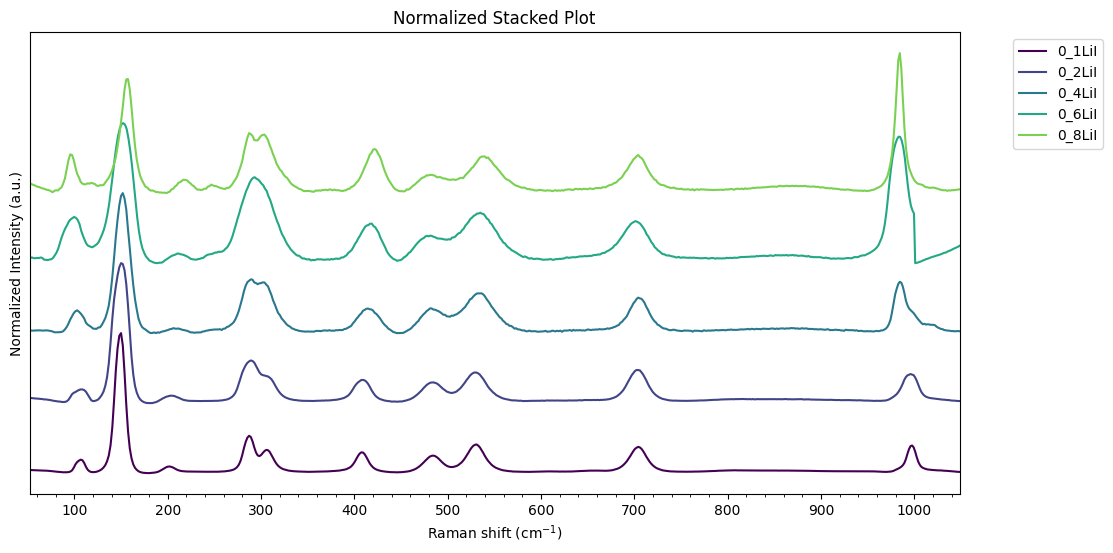

In [34]:
stack_plot_bs_norm(r"C:\Users\write\OneDrive\Documents\Banerjee_Lab\Projects\Vanadium_Oxide\RAMAN\li_a_V2O5\improved\New_plots\*.txt", r"C:\Users\write\OneDrive\Documents\Banerjee_Lab\Projects\Vanadium_Oxide\RAMAN\li_a_V2O5\improved\New_plots\stack_plot", lam_value = 1e4, size=(12, 6), offset=50)

In [6]:
txt_files= glob.glob(r"C:\Users\write\Downloads\carlos_raman\*.txt")

In [11]:
txt_files

['C:\\Users\\write\\Downloads\\carlos_raman\\250618_Pristine_dCo_10minscan_CAL.txt',
 'C:\\Users\\write\\Downloads\\carlos_raman\\250618_Pristine_dK_10minscan_CAL.txt',
 'C:\\Users\\write\\Downloads\\carlos_raman\\250618_Pristine_dNa_10minscan.txt',
 'C:\\Users\\write\\Downloads\\carlos_raman\\250618_Pristine_dNi_10minscan_CAL.txt',
 'C:\\Users\\write\\Downloads\\carlos_raman\\250618_Pristine_dZn_10minscan_CAL.txt']

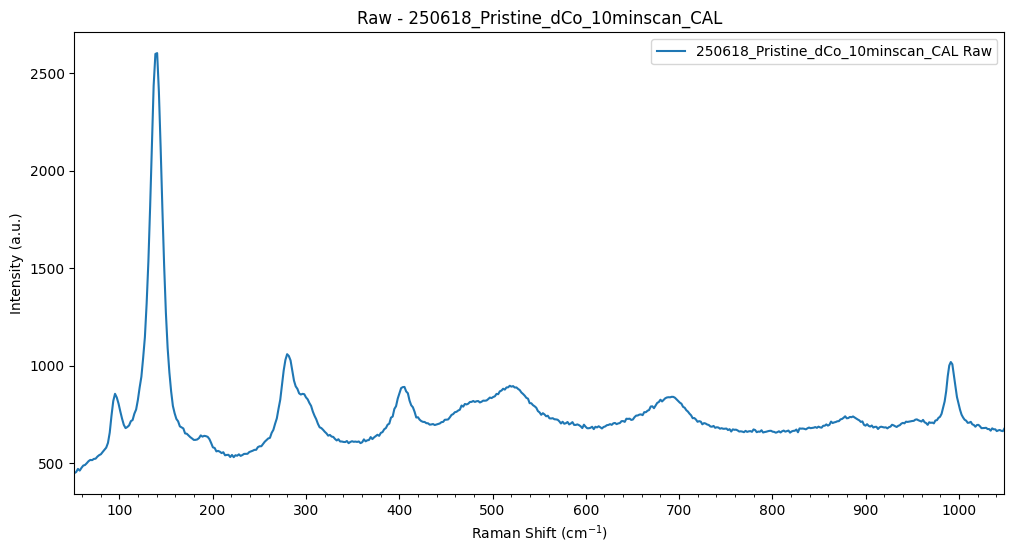

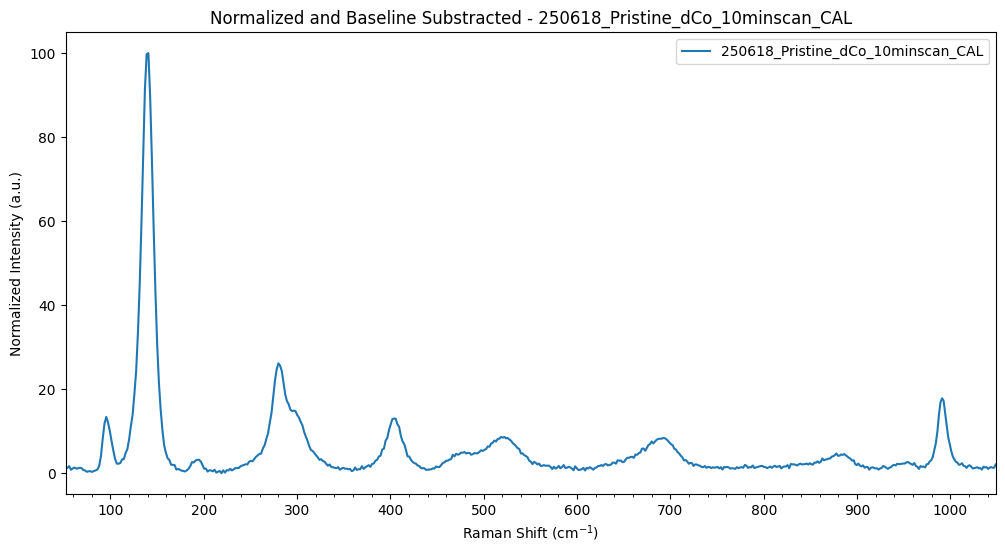

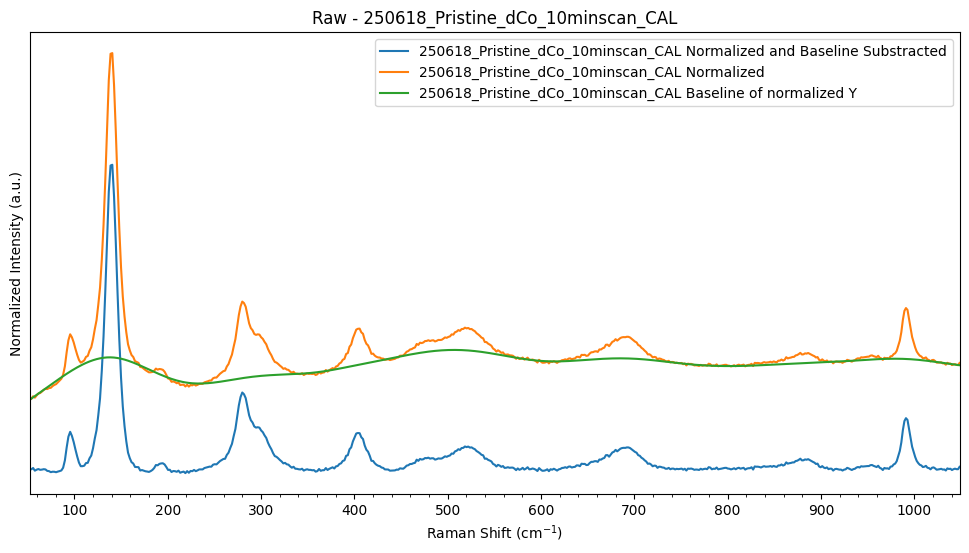

Plot have been saved to C:\Users\write\Downloads\carlos_raman\plots1


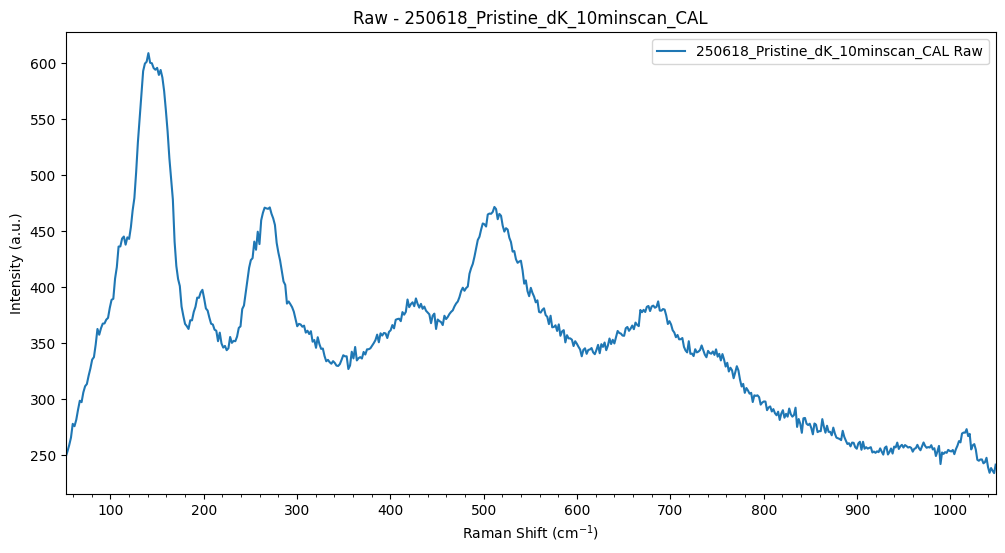

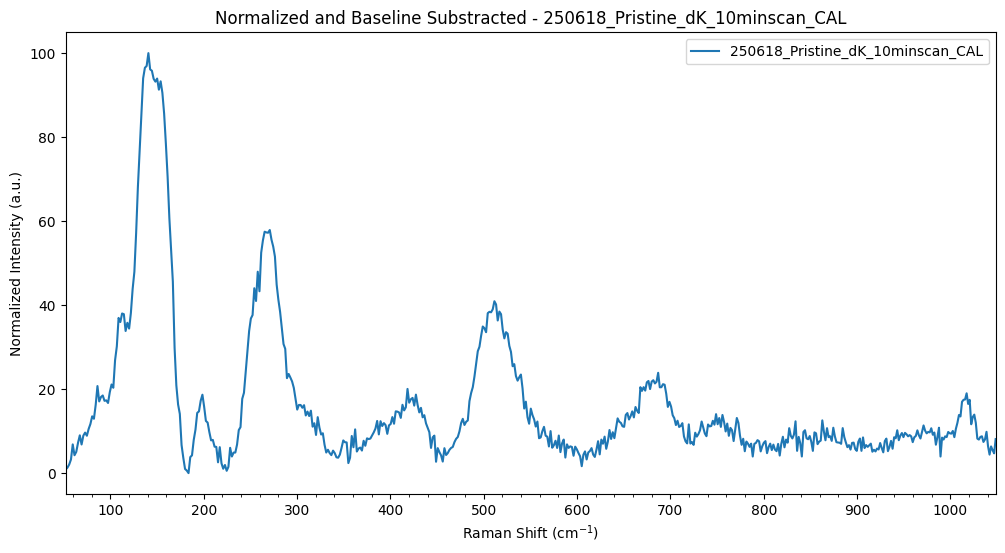

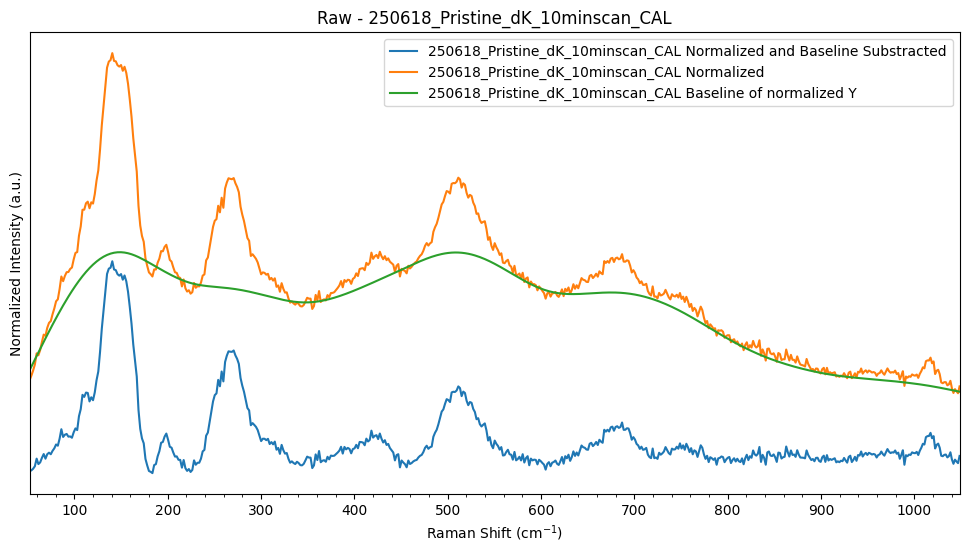

Plot have been saved to C:\Users\write\Downloads\carlos_raman\plots1


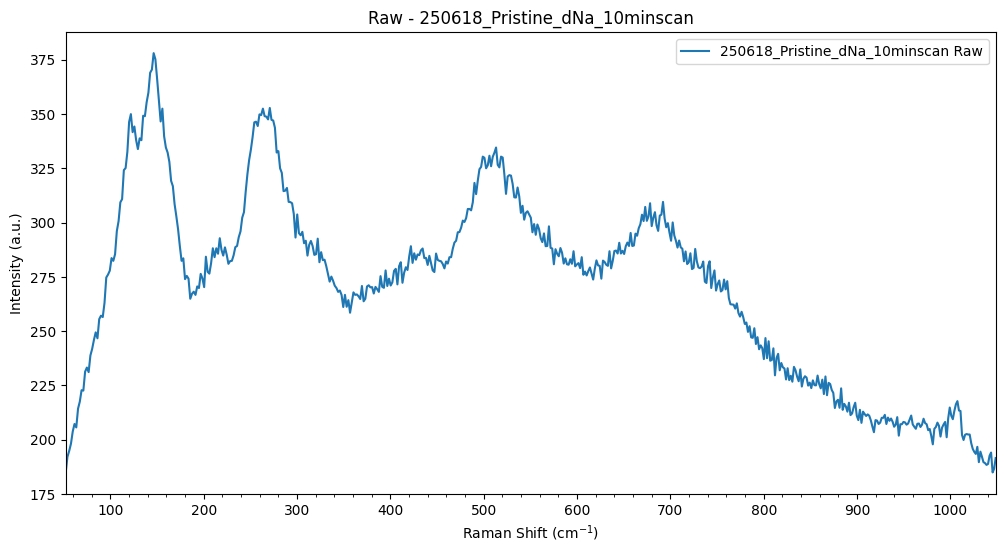

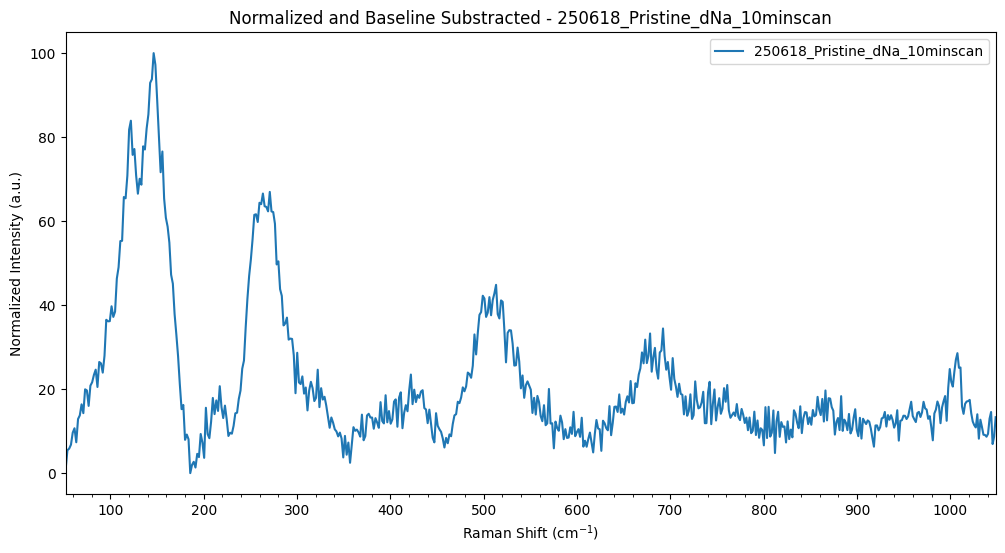

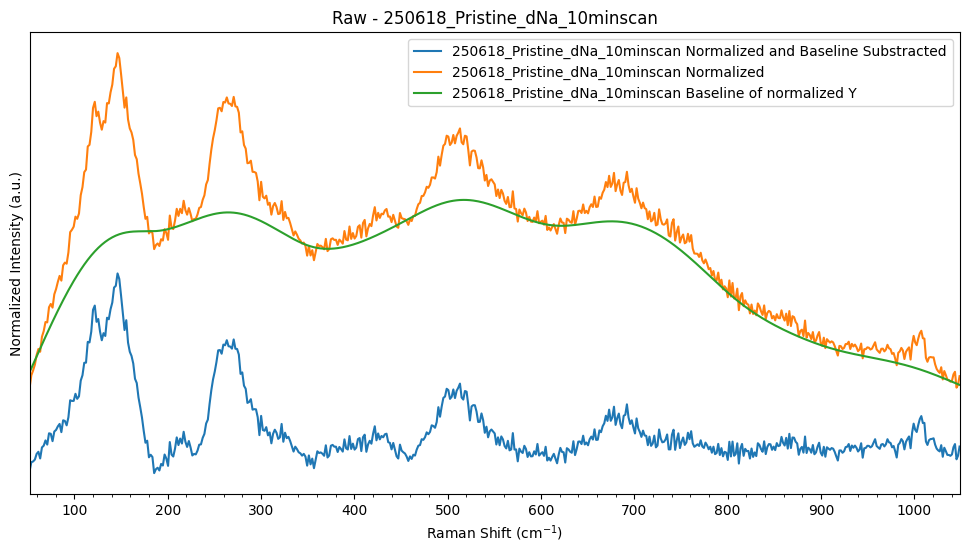

Plot have been saved to C:\Users\write\Downloads\carlos_raman\plots1


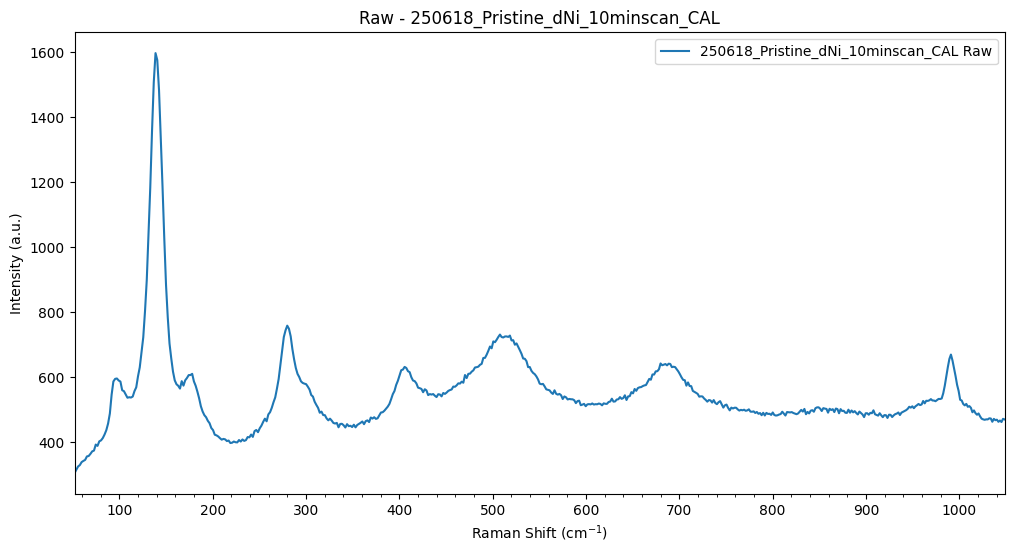

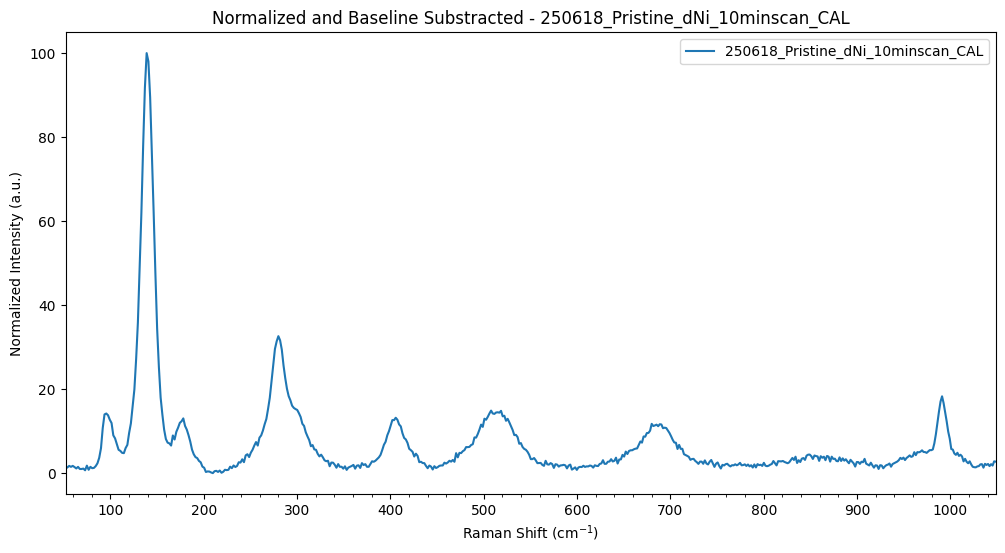

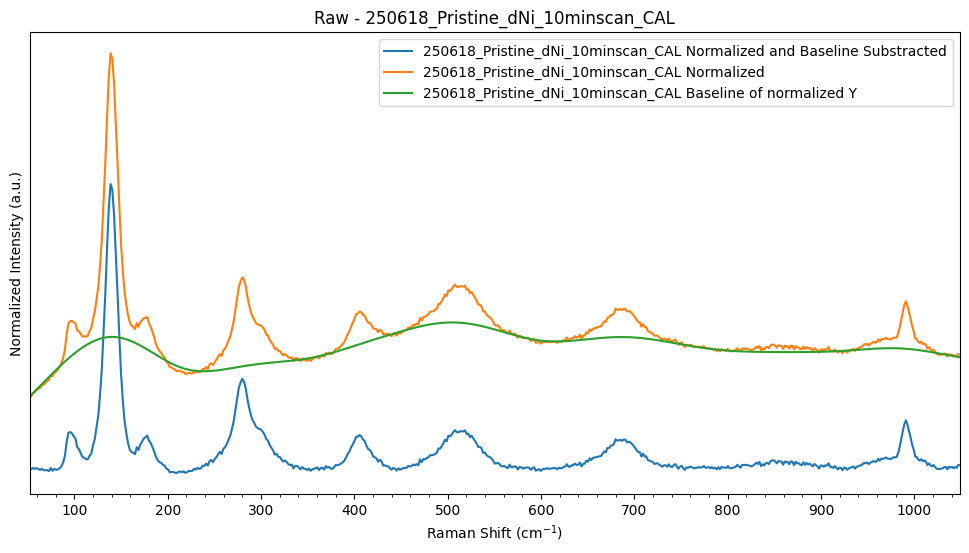

Plot have been saved to C:\Users\write\Downloads\carlos_raman\plots1


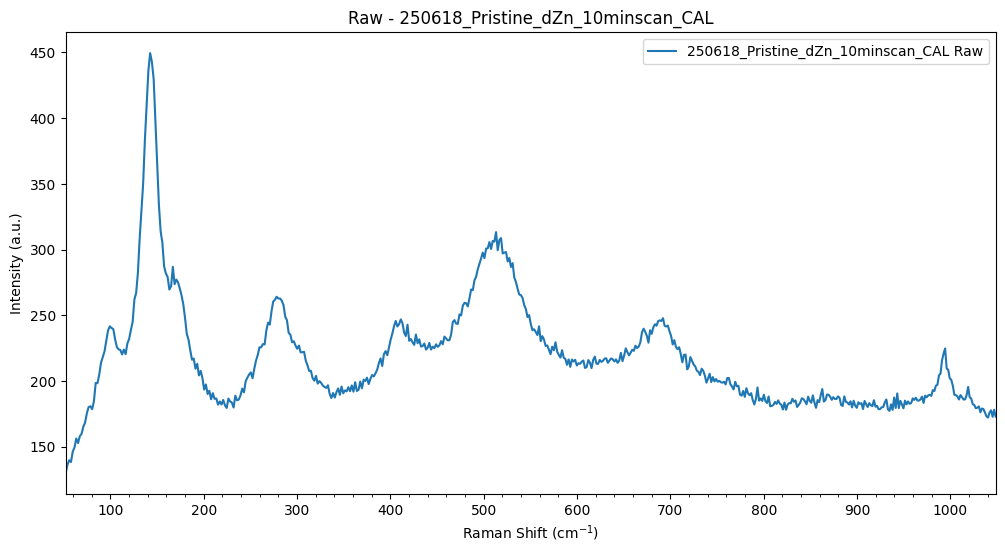

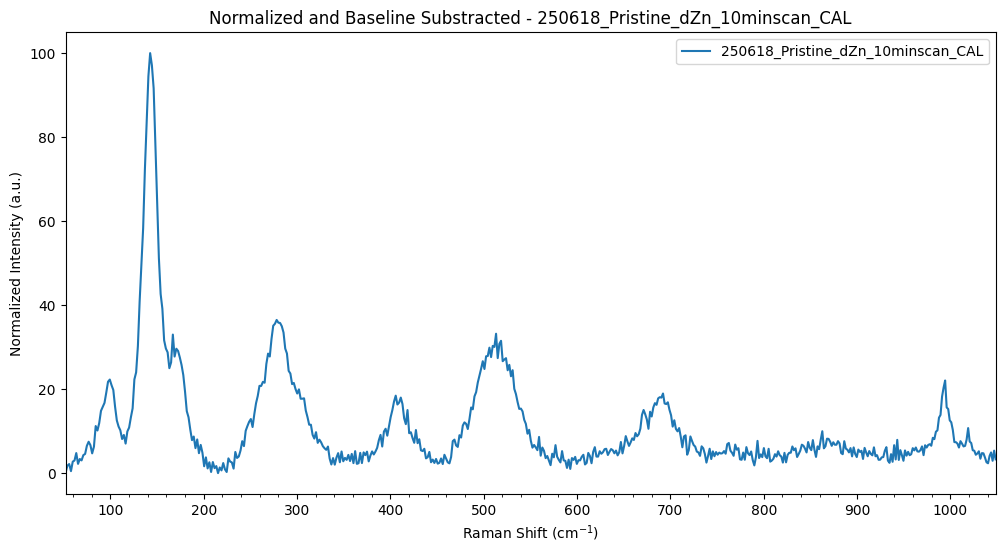

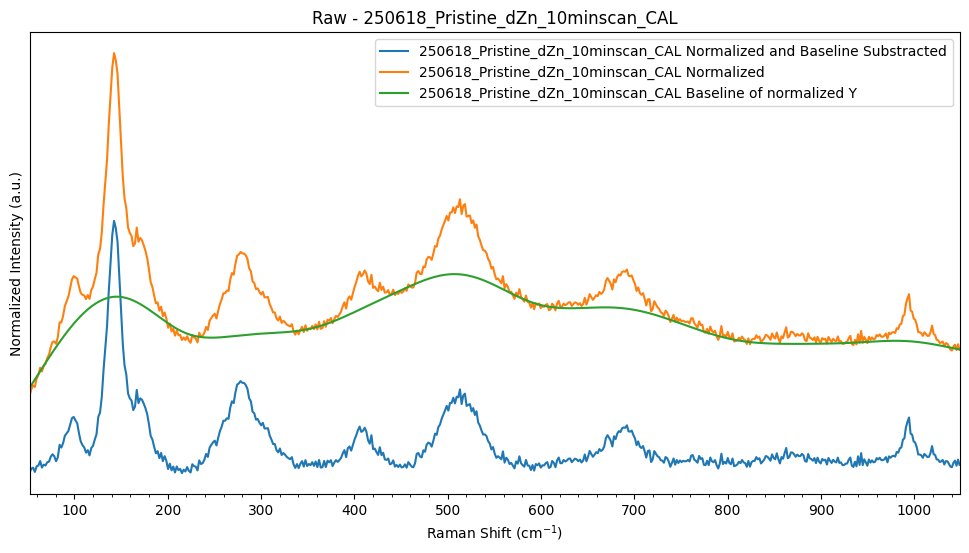

Plot have been saved to C:\Users\write\Downloads\carlos_raman\plots1


In [9]:
for txt in txt_files:
    plot_baseline_corrected_data(txt, r"C:\Users\write\Downloads\carlos_raman\plots1", lam_value=1e4, size=(12,6))
    

C:\Users\write\AppData\Local\Temp\ipykernel_21136\328439429.py:220: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colormap =  cm.get_cmap('viridis')


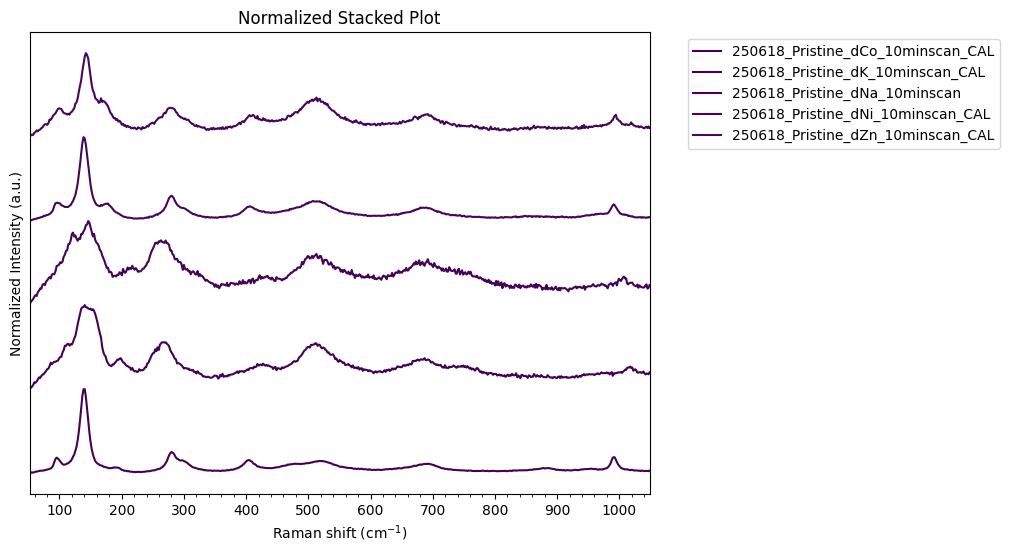

In [12]:
stack_plot_bs_norm(r"C:\Users\write\Downloads\carlos_raman\*.txt", r"C:\Users\write\Downloads\carlos_raman\plots", offset = 100)

In [ ]:
file=r"C:\Users\write\OneDrive\Documents\Banerjee_Lab\Projects\Vanadium_Oxide\RAMAN\li_a_V2O5\plots\Pristine.txt"

In [ ]:
plot_baseline_corrected_data(file, peak_range=(350, 450))

ValueError: All arrays must be of the same length

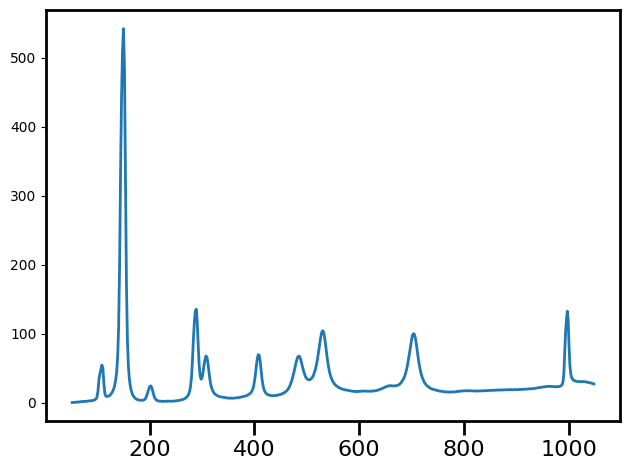

In [ ]:
ndata  = normalize_data(x,y, peak_range=(600, 800))
plt.plot(x, ndata)

In [7]:
    def comma_to_float(s):
        return float(s.replace(b',', b'.'))

In [ ]:
file = r"C:\Users\write\Downloads\carlos_raman\250618_Pristine_dZn_10minscan_CAL.txt"

In [10]:
data = np.loadtxt(file, converters={0: comma_to_float, 1: comma_to_float})
data

array([[  51.9863,  129.947 ],
       [  53.8845,  136.263 ],
       [  55.7801,  139.737 ],
       ...,
       [1045.25  ,  172.789 ],
       [1046.88  ,  178.158 ],
       [1048.51  ,  173.    ]])

In [1]:
print('done')

done


In [54]:
def stack_plot_from_files(folder_path, outpath = '', offset = 10, no_of_plots = 10, lam_value=1e7, p_value=0.02, x_min=None, x_max=None, peak_range=None, size=(8,6)):      #color_index chooses color from the colors list 
    """Ploting stack from text files and save data"""
    txt_files = glob.glob(folder_path)
    txt_files.sort()
    fig, ax = plt.subplots(figsize=size)
    i = 0

    colormap =  cm.get_cmap('Dark2')
    
    for txt_file in txt_files:
        file_name = os.path.splitext(os.path.basename(txt_file))[0]     #Getting the filename without the extension for final filename
        raman = pd.read_csv(txt_file, sep='\t')
        x = raman['Raman Shift']
        y = raman['Normalized and Baseline Substracted']
        
        if x_min == None:
                x_min = min(x)
        if x_max == None:
                x_max = max(x)
        color =  colormap(i)
        
        ax.plot(x, y + i*offset, label = file_name, color=color, alpha = 1)
        i += 1
        if i == no_of_plots:
            break
        
    plt.tick_params(labelleft = False ,left=False)
    ax.xaxis.set_major_locator(MultipleLocator(100))
    ax.xaxis.set_minor_locator(MultipleLocator(20))
    plt.xlim(x_min, x_max)     #For croping on xaxis 
    plt.xlabel('Raman shift (cm$^{-1}$)')
    plt.ylabel('Normalized Intensity (a.u.)')
    plt.title("Normalized Stacked Plot" )
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.show()
    os.makedirs(outpath, exist_ok=True)      #Checking if the output directory exsits otherwise creates one
    fig.savefig(outpath + '/' + 'stacked_normalized.svg', format='svg')

In [6]:
stack_plot_from_files(out_path = r"C:\Users\write\OneDrive\Documents\Banerjee_Lab\Projects\Vanadium_Oxide\RAMAN\li_a_V2O5\improved\New_plots\plot_figs", offset=50, peak_range=(900, 1050))

NameError: name 'stack_plot_from_files' is not defined

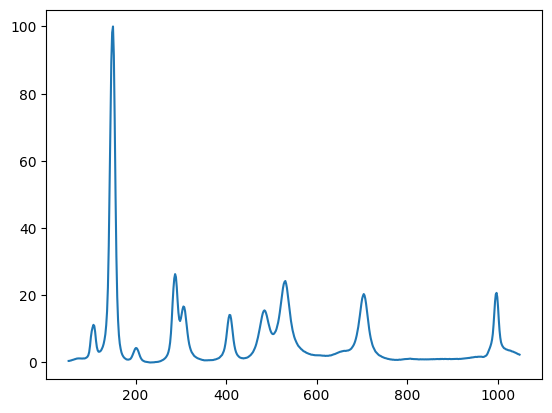

In [ ]:
file= r"C:\Users\write\OneDrive\Documents\Banerjee_Lab\Projects\Vanadium_Oxide\RAMAN\li_a_V2O5\improved\New_plots\plot_figs\0_1LiI_processed.txt"
data = pd.read_csv(file, sep="\t")
x = data['Raman Shift']
y = data['Normalized and Baseline Substracted']
plt.plot(x, y)

C:\Users\write\AppData\Local\Temp\ipykernel_13180\3634183546.py:221: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colormap =  cm.get_cmap('viridis', 6)


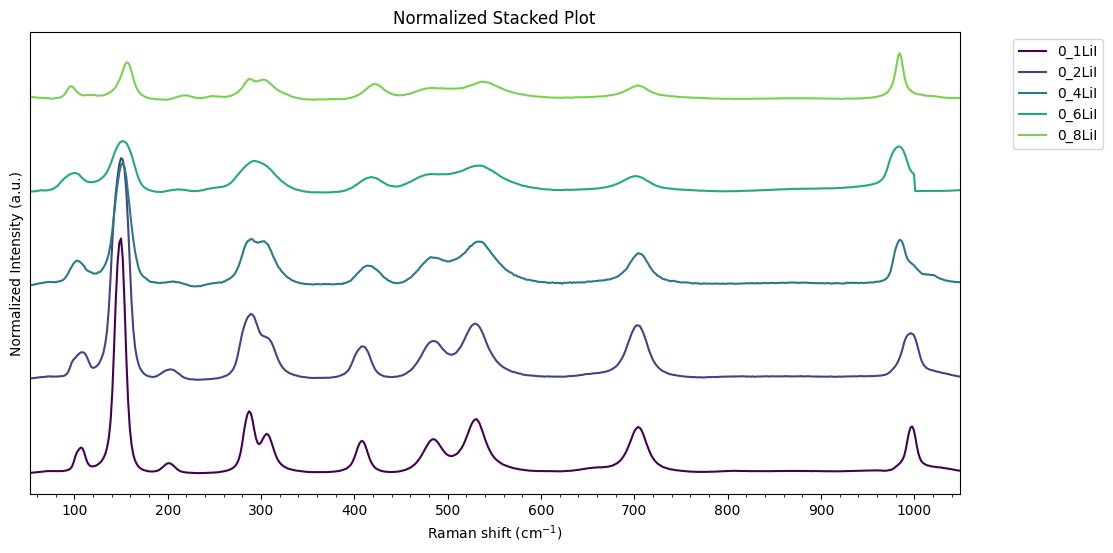

In [11]:
stack_plot_bs_norm(r"C:\Users\write\OneDrive\Documents\Banerjee_Lab\Projects\Vanadium_Oxide\RAMAN\li_a_V2O5\improved\Old_plots\Selected\*.txt", r"C:\Users\write\OneDrive\Documents\Banerjee_Lab\Projects\Vanadium_Oxide\RAMAN\li_a_V2O5\improved\New_plots\plot_figs\stack", lam_value=1e6, size=(12, 6), offset=200, peak_range=(900,1000))